# SET UP

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!pip install -U sentence-transformers
!pip install -U numpy
!pip install kneed

In [ ]:
# A Python interface to the Penn Discourse Treebank 2
!git clone https://github.com/cgpotts/pdtb2.git

Cloning into 'pdtb2'...
remote: Enumerating objects: 48, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 48 (delta 21), reused 48 (delta 21), pack-reused 0
Unpacking objects: 100% (48/48), done.


In [4]:
%cd /content/gdrive/MyDrive/computational discourse/pdtb2

/content/gdrive/MyDrive/computational discourse/pdtb2


In [6]:
#import statements
from sklearn.cluster import KMeans
import numpy as np
from pdtb2 import CorpusReader, Datum
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import time
from collections import Counter
import pandas as pd

# Data Extraction and Preprocessing

In [ ]:
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModel
import torch

model_sent = SentenceTransformer('all-mpnet-base-v2')
qa_search = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')
semantic_serch = SentenceTransformer('sentence-transformers/msmarco-distilbert-dot-v5')# not good

def sent_transformer(sentences):
  embeddings = qa_search.encode(sentences)
  return embeddings

#reference : https://huggingface.co/sentence-transformers/bert-base-nli-mean-tokens
#https://huggingface.co/SpanBERT/spanbert-base-cased

'''
#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

# Load model from HuggingFace Hub
tokenizer = AutoTokenizer.from_pretrained('mrm8488/spanbert-large-finetuned-tacred')
model_spanBert = AutoModel.from_pretrained('mrm8488/spanbert-large-finetuned-tacred')

# This takes too much time to extract
def span_bert(sentences):
  # Tokenize sentences
  encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')

  # Compute token embeddings
  with torch.no_grad():
      model_output = model_spanBert(**encoded_input)

  # Perform pooling. In this case, max pooling.
  sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
  sentence_embeddings=[x.cpu() for x in sentence_embeddings]
  return sentence_embeddings
'''

In [112]:
#Read in Data
X_sentences = []
y = []
rel_tag = []
iterator = CorpusReader('pdtb2.csv').iter_data(display_progress=False)
try:
    while(True):
        d = next(iterator)
        arg1 = d.Arg2_RawText
        arg2 = d.Arg2_Attribution_RawText
        relation = d.Relation
        connection = None
        if relation == "Explicit":
            connection = str(d.ConnHead).lower()
            X_sentences.append([str(d.Arg1_RawText).lower(),
                                str(d.ConnHead).lower(),
                                str(d.Arg2_RawText).lower()])
            y.append(str(d.ConnHead).lower())
            rel_tag.append(str(d.ConnHeadSemClass1).lower())
        '''
        if relation=="Implicit":
            connection=d.Conn1
            X_sentences.append([d.Arg1_RawText,connection,d.Arg2_RawText])
            y.append(connection)
        '''
except:
    print("end")

end


In [113]:
# arg1 sentence and arg2 sentence
X_sentences[2]

['that hung over parts of the factory',
 'though',
 'exhaust fans ventilated the area']

In [114]:
#connective phrase
y[2]

'though'

In [115]:
len(X_sentences)

18459

In [83]:
sent_transformer(X_sentences[0])

array([[ 0.0057285 ,  0.12435857, -0.01295577, ...,  0.04712886,
         0.02709456,  0.00023316],
       [-0.06562962,  0.0242894 , -0.06700323, ..., -0.07716344,
         0.11224264,  0.00800856],
       [-0.05350126,  0.06687994,  0.04073662, ..., -0.03744461,
         0.05493079,  0.081355  ]], dtype=float32)

In [116]:
def concate(arg1,conn,arg2):
    return np.concatenate(arg1,conn,arg2)
def similarity(arg1,conn,arg2):
    return np.concatenate([arg1, conn, arg2, np.absolute(np.subtract(arg1,arg2)), [np.dot(arg1,arg2)]])
def dot_product(arg1,conn,arg2):
    return np.concatenate([[np.dot(arg1,arg2)]])
n=len(X_sentences)

In [117]:
# extract features use bert sentence transformers and concatenate two embedings.
# reference : https://huggingface.co/sentence-transformers/bert-base-nli-mean-tokens
# save features to file because it cost a lot of time extracting the features

n = len(X_sentences)
with open('features.npy', 'wb') as f:
  c = 0
  start = time.time()
  for sentences in X_sentences:
    feature = np.concatenate(model.encode(sentences))
    np.save(f, feature)
    if c % 1000 == 0:
      print(str(c) + "/" + str(n) + " complete.")
    if c % n == 0:
      print(str(c) + "/" + str(n) + " complete.")
    c += 1
  end = time.time()
  print("Total runtime: {} seconds".format(round(end - start, 2)))

0/18459
0.17486143112182617
1000/18459
7.647238492965698
2000/18459
7.462528705596924
3000/18459
7.393226385116577
4000/18459
10.541001558303833
5000/18459
7.476747035980225
6000/18459
7.323578834533691
7000/18459
7.43869161605835
8000/18459
7.3367273807525635
9000/18459
7.2940123081207275
10000/18459
7.387101650238037
11000/18459
7.298447847366333
12000/18459
7.41251277923584
13000/18459
7.348384618759155
14000/18459
7.464084625244141
15000/18459
7.305728197097778
16000/18459
7.316617727279663
17000/18459
7.4206976890563965
18000/18459
7.363481044769287


In [118]:
# load features from file

X = []
with open('features.npy', 'rb') as f:
  for _ in range(n):
    X.append(np.load(f,allow_pickle=True))

In [119]:
len(X)

18459

In [120]:
def view_labels(X, X_sentences, algo_labels, u, level="secondary"):
  # algo_labels is labels as found by the algorithm in 1D array form
  # u is number of clusters

  arg1s = [x[0] for x in X_sentences]
  arg2s = [x[2] for x in X_sentences]
  arg_conn = [x[1] for x in X_sentences]
  arg_label = [y for y in rel_tag]
  df = pd.DataFrame([arg1s,arg2s,arg_conn,algo_labels, arg_label]).transpose()
  df.columns = ['arg1','arg2','connective', 'algo', 'pdtb_tag']

  df[['primary', 'secondary', 'tertiary']] = df.pdtb_tag.str.split('.', expand=True)
  df['primary'] = df['primary'].fillna("<empty_1>")
  df['secondary'] = df['secondary'].fillna("<empty_2>")
  df['tertiary'] = df['tertiary'].fillna("<empty_3>")

  labels = []
  for label in range(u):
    df2 = df[df['algo'] == label]
    tmp_list1 = set(df2["connective"])
    [x, y] = [label, [tmp_list1]]
    labels.append([x,y])

  connective_to_label = []
  for word in range(len(list(set(df["connective"])))):
    connective = list(set(df["connective"]))[word] 
    df2 = df[df["connective"] == connective]
    tmp_list2 = set(df2["algo"])
    [x,y] = [connective, [tmp_list2]]
    connective_to_label.append([x,y])

  pdtb_connective_to_label = []
  for word in range(len(list(set(df["connective"])))):
    connective = list(set(df["connective"]))[word] 
    df2 = df[df["connective"] == connective]
    tmp_list3 = set(df2[level])
    [x,y] = [connective, [tmp_list3]]
    pdtb_connective_to_label.append([x,y])

  pdtb_label_connectives = []
  for label in range(len(list(set(df[level])))):
    label_word = list(set(df[level]))[label]
    df2 = df[df[level] == label_word]
    tmp_list4 = set(df2["connective"])
    [x, y] = [label_word, [tmp_list4]]
    pdtb_label_connectives.append([x,y])

  algo_to_pdtb = []
  for label in range(u):
    df2 = df[df['algo'] == label]
    tmp_list5 = set(df2[level])
    [x, y] = [label, [tmp_list5]]
    algo_to_pdtb.append([x,y])

  pdtb_to_algo = []
  for label in range(len(list(set(df[level])))):
    label_word = list(set(df[level]))[label]
    df2 = df[df[level] == label_word]
    tmp_list6 = set(df2["algo"])
    [x, y] = [label_word, [tmp_list6]]
    pdtb_to_algo.append([x,y])

  return df, labels, connective_to_label, pdtb_connective_to_label, pdtb_label_connectives, algo_to_pdtb, pdtb_to_algo

# KMEANS

In [64]:
# unique connectives 
#u=len(set(y))
u = 20

In [65]:
# reference : https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
kmeans = KMeans(n_clusters = u, 
                random_state=0).fit(X)

In [66]:
# (connective, predicted label),frequency
#counter=Counter(zip(y,kmeans.labels_))
#counter.most_common(10)

In [67]:
df, labels_K, connective_to_label_K, pdtb_conn_labels, pdtb_labels, algo_pdtb, pdtb_algo = view_labels(X, X_sentences, kmeans.labels_, u)

In [68]:
labels_K

[[0,
  [{'accordingly',
    'additionally',
    'after',
    'afterward',
    'also',
    'alternatively',
    'although',
    'and',
    'as',
    'as a result',
    'as an alternative',
    'as if',
    'as long as',
    'as soon as',
    'as though',
    'as well',
    'because',
    'before',
    'besides',
    'but',
    'by comparison',
    'by contrast',
    'by then',
    'consequently',
    'earlier',
    'else',
    'except',
    'finally',
    'for',
    'for example',
    'for instance',
    'further',
    'furthermore',
    'hence',
    'however',
    'if',
    'if and when',
    'if then',
    'in addition',
    'in contrast',
    'in fact',
    'in other words',
    'in particular',
    'in short',
    'in the end',
    'in turn',
    'indeed',
    'insofar as',
    'instead',
    'later',
    'lest',
    'likewise',
    'meantime',
    'meanwhile',
    'moreover',
    'much as',
    'neither nor',
    'nevertheless',
    'next',
    'nonetheless',
    'nor',
    'now th

In [69]:
connective_to_label_K

[['in short', [{0, 2, 3}]],
 ['however', [{0, 1, 2, 3, 4}]],
 ['rather', [{0, 1, 2, 3, 4}]],
 ['as an alternative', [{0, 3}]],
 ['yet', [{0, 1, 2, 3, 4}]],
 ['further', [{0, 1, 3, 4}]],
 ['after', [{0, 1, 2, 3, 4}]],
 ['then', [{0, 1, 2, 3, 4}]],
 ['afterward', [{0, 1, 2, 3}]],
 ['likewise', [{0, 1, 3, 4}]],
 ['whereas', [{1, 3}]],
 ['furthermore', [{0, 1, 3, 4}]],
 ['and', [{0, 1, 2, 3, 4}]],
 ['unless', [{0, 1, 2, 3, 4}]],
 ['plus', [{3}]],
 ['thus', [{0, 1, 2, 3, 4}]],
 ['when', [{0, 1, 2, 3, 4}]],
 ['overall', [{0, 1, 3, 4}]],
 ['previously', [{0, 1, 2, 3, 4}]],
 ['as', [{0, 1, 2, 3, 4}]],
 ['therefore', [{0, 1, 2, 3, 4}]],
 ['conversely', [{1, 4}]],
 ['thereby', [{0, 1, 2, 3, 4}]],
 ['nevertheless', [{0, 1, 2, 3, 4}]],
 ['moreover', [{0, 1, 2, 3, 4}]],
 ['for', [{0, 1, 3}]],
 ['in particular', [{0, 1, 2, 3}]],
 ['or', [{0, 1, 2, 3, 4}]],
 ['for example', [{0, 1, 2, 3, 4}]],
 ['as soon as', [{0, 1, 2, 3}]],
 ['consequently', [{0, 1, 2, 3, 4}]],
 ['hence', [{0, 3}]],
 ['similarly', 

In [70]:
cols = [i for i in range(u)]
conntive_clusters = [list(x[1][0]) for x in labels_K]
df = pd.DataFrame(conntive_clusters).transpose()
df.columns = cols
df

,0,1,2,3,4
0,in short,however,also,in short,also
1,however,rather,meanwhile,however,meanwhile
2,rather,yet,however,rather,in addition
3,as an alternative,further,in short,as an alternative,however
4,yet,after,if and when,yet,if then
...,...,...,...,...,...
85,though,None,None,except,None
86,additionally,None,None,though,None
87,insofar as,None,None,till,None
88,earlier,None,None,specifically,None


In [71]:
from pathlib import Path  
filepath = Path('out_dotproduct_5_semanticSearchEmbedding.csv')  
#filepath.parent.mkdir(parents=True, exist_ok=True)  
df.to_csv(filepath)  

In [ ]:
!pwd

/content/gdrive/MyDrive/computational discourse/pdtb2


# KMEANS on a range

In [62]:


distortions = []
K = range(1,30)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X)
    distortions.append(kmeanModel.inertia_)
    print(k)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


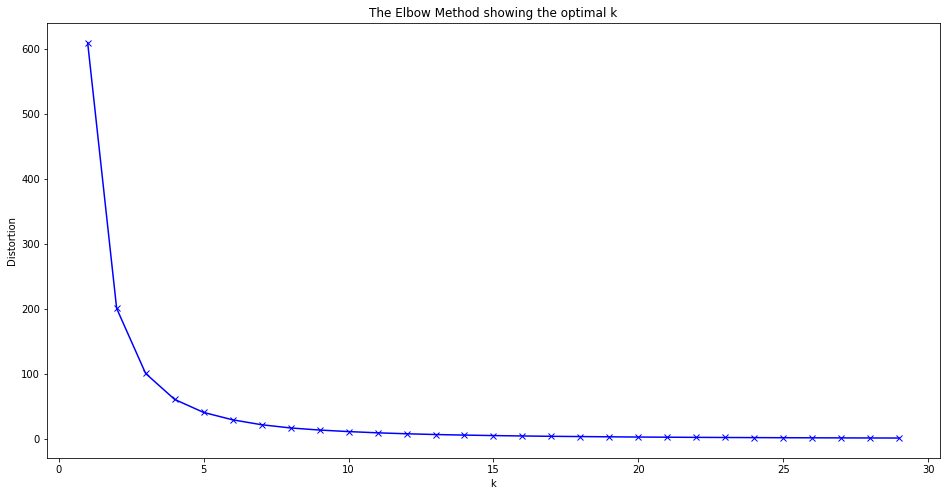

In [63]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [ ]:
#Notes from Jay
#run kmeans instead on the full sentence so that the connective is 
#appropriately contextualized

# Then either concatenate the connective's embedding on its own
# to the end of the sentence
# or some other transformation dot(full_sentence, connective)
# and pass that through into k-means
# also dont forget to put the entire sentence as lowercase
# or uppercase if you feel angry.

# t-SNE Visualization using KMeans Clusters

https://builtin.com/data-science/unsupervised-learning-python
"One of the unsupervised learning methods for visualization is t-distributed stochastic neighbor embedding, or t-SNE. It maps high-dimensional space into a two or three-dimensional space which can then be visualized. Specifically, it models each high-dimensional object by a two- or three-dimensional point in such a way that similar objects are modeled by nearby points and dissimilar objects are modeled by distant points with high probability"

In [34]:
# Defining Model
model = TSNE(learning_rate=100)
# Fitting Model
transformed = model.fit_transform(X)
num_clusters = 11

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


KeyboardInterrupt: ignored

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* a

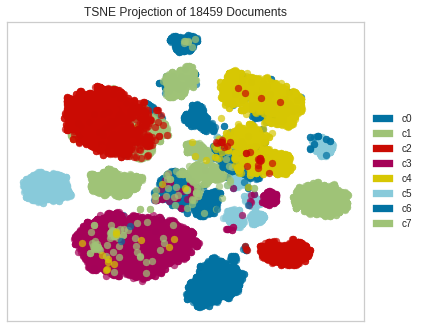

In [ ]:
from yellowbrick.text import TSNEVisualizer
clusters = KMeans(n_clusters=num_clustesrs)
clusters.fit(transformed)

tsne = TSNEVisualizer()
tsne.fit(X, ["c{}".format(c) for c in clusters.labels_])
tsne.show()

In [ ]:
labels_tSNE,connective_to_label_tSNE = view_labels(X, X_sentences, clusters.labels_, num_clusters)

NameError: ignored

In [ ]:
labels_tSNE

[[0,
  [{'afterward',
    'also',
    'alternatively',
    'although',
    'and',
    'as an alternative',
    'as well',
    'before',
    'besides',
    'but',
    'by then',
    'else',
    'finally',
    'for',
    'however',
    'if',
    'in fact',
    'in other words',
    'in particular',
    'in short',
    'in sum',
    'in the end',
    'in turn',
    'insofar as',
    'later',
    'likewise',
    'moreover',
    'on the contrary',
    'regardless',
    'separately',
    'specifically',
    'then',
    'though',
    'ultimately',
    'whereas'}]],
 [1,
  [{'and',
    'but',
    'by comparison',
    'by contrast',
    'however',
    'in contrast',
    'meantime',
    'meanwhile',
    'nevertheless',
    'nonetheless',
    'on the one hand on the other hand',
    'on the other hand',
    'still',
    'though',
    'whereas',
    'while',
    'yet'}]],
 [2,
  [{'also',
    'and',
    'as',
    'as though',
    'conversely',
    'indeed',
    'much as',
    'overall'}]],
 [3,
  

In [ ]:
connective_to_label_tSNE

# Affinity Propogation

https://scikit-learn.org/stable/modules/clustering.html
"AffinityPropagation creates clusters by sending messages between pairs of samples until convergence. A dataset is then described using a small number of exemplars, which are identified as those most representative of other samples. The messages sent between pairs represent the suitability for one sample to be the exemplar of the other, which is updated in response to the values from other pairs. This updating happens iteratively until convergence, at which point the final exemplars are chosen, and hence the final clustering is given."

Not enough RAM to do this

In [ ]:
from sklearn.cluster import AffinityPropagation
# Fit Affinity Propagation with Scikit
afprop = AffinityPropagation(max_iter=250)
afprop.fit(X)
cluster_centers_indices = afprop.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)
# Predict the cluster for all the samples
P = afprop.predict(X)


# Mean-Shift

https://scikit-learn.org/stable/modules/clustering.html

MeanShift clustering aims to discover blobs in a smooth density of samples. It is a centroid based algorithm, which works by updating candidates for centroids to be the mean of the points within a given region. These candidates are then filtered in a post-processing stage to eliminate near-duplicates to form the final set of centroids.

In [ ]:
from sklearn.cluster import MeanShift
ms = MeanShift(max_iter = 10)
ms.fit(X)


KeyboardInterrupt: ignored

In [ ]:
num_clusters = len(set(ms.labels))
labels_MS,connective_to_label_MS = view_labels(X, X_sentences, ms.labels, num_clusters)



# Hierarchal Clustering

In [ ]:
from sklearn.cluster import AgglomerativeClustering
clustering = AgglomerativeClustering(n_clusters = 4).fit(X)
clustering.labels_

# DBSCAN

Following: https://towardsdatascience.com/how-to-use-dbscan-effectively-ed212c02e62

the linear boundary of the k-means clustering definitely does not work well. However, DBSCAN doesn’t require any shape of the clusters but tracks the high-density regions

There are a few implicit assumptions in this approach:
*   Densities across all the clusters are the same.
*   Cluster sizes or standard deviations are the same.


A large eps tend to include more points within a cluster, so a too-large eps will include everything in the same single cluster and a too-small eps will result in no clustering at all.

A too-small minPts is not meaningful because it will regard every point as a core point. A relatively larger minPts can be better to deal with data with more noises.

In [ ]:
#use nearest neighbors to help calculate our eps argument with dbscan

In [121]:
from sklearn.neighbors import NearestNeighbors
#https://scikit-learn.org/stable/modules/neighbors.html
#start by using sqrt(N) for number of neighbors

#two different approaches
#num_neighs = round(len(X)/11) #naively we expect around 11 clusters 
num_neighs = round(np.sqrt(len(X)))

nearest_neighbors = NearestNeighbors(n_neighbors=num_neighs)
neighbors = nearest_neighbors.fit(transformed)
distances, indices = neighbors.kneighbors(transformed)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


Text(0, 0.5, 'Distance')

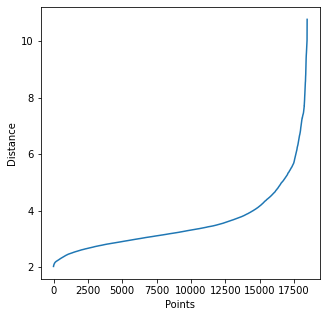

In [122]:
#plot
distances_sorted = np.sort(distances[:,25-1], axis=0)
fig = plt.figure(figsize=(5, 5))
plt.plot(distances_sorted)
plt.xlabel("Points")
plt.ylabel("Distance")

#When num_neighs = len(X)/11 -- could look at other elbow point in data

4.490108263415913


<Figure size 360x360 with 0 Axes>

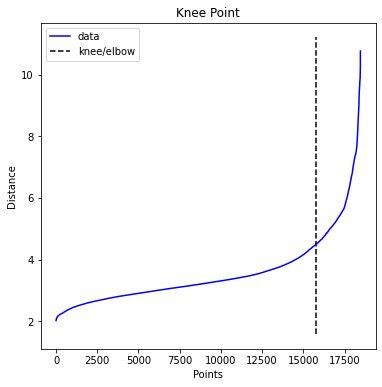

In [123]:
#find eps from the above graph using KneeLocator to Detect Elbow Point
from kneed import KneeLocator
i = np.arange(len(distances))
knee = KneeLocator(i, distances_sorted, S=1, curve='convex', direction='increasing', interp_method='polynomial')
fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")

print(knee.knee_y)

In [124]:
from sklearn.cluster import DBSCAN
eps = knee.knee_y
DBSCAN_cluster = DBSCAN(eps=eps, min_samples=25).fit(transformed)
#print(DBSCAN_cluster.labels_)

In [125]:
num_outliers = np.sum(DBSCAN_cluster.labels_ == -1)
num_clusters = len(np.unique(DBSCAN_cluster.labels_)) - 1
percentage_outliers = num_outliers/len(DBSCAN_cluster.labels_) * 100
print("Num_outliers: " + str(num_outliers))
print("Num_clusters: " + str(num_clusters))
print("Percentage of points that are outliers: " + str(percentage_outliers))

Num_outliers: 325
percentage of points that are outliers: 1.760658757245788


In [126]:
DBSCAN_labels = DBSCAN_cluster.labels_
if (num_outliers > 0):
  #if there are outliers in the data, shift the data up to print the unlustered data, otherwise leave as is
  DBSCAN_labels = DBSCAN_labels + 1
labels_DBSCAN,connective_to_label_DBSCAN, _, _, _, _, _ = view_labels(X, X_sentences, DBSCAN_labels, len(set(DBSCAN_labels)))

In [127]:
labels_DBSCAN

[[0,
  [{'also',
    'although',
    'and',
    'as',
    'as long as',
    'but',
    'finally',
    'however',
    'if',
    'in the end',
    'indeed',
    'instead',
    'once',
    'previously',
    'separately',
    'so',
    'still',
    'then',
    'unless',
    'when',
    'while',
    'yet'}]],
 [1,
  [{'And',
    'accordingly',
    'additionally',
    'after',
    'afterward',
    'also',
    'alternatively',
    'although',
    'and',
    'as',
    'as a result',
    'as an alternative',
    'as if',
    'as long as',
    'as soon as',
    'as though',
    'as well',
    'because',
    'before',
    'besides',
    'but',
    'by comparison',
    'by contrast',
    'by then',
    'consequently',
    'conversely',
    'earlier',
    'either or',
    'else',
    'except',
    'finally',
    'for',
    'for example',
    'for instance',
    'further',
    'furthermore',
    'hence',
    'however',
    'if',
    'if and when',
    'if then',
    'in addition',
    'in contrast',

In [128]:
u = len(labels_DBSCAN)
cols = [i for i in range(u)]
conntive_clusters = [list(x[1][0]) for x in labels_DBSCAN]
df = pd.DataFrame (conntive_clusters).transpose()
df.columns = cols
df

,0,1,2,3,4,5
0,while,next,while,before and after,till,but
1,if,afterward,as,finally,until,in addition
2,when,thereafter,but,before,None,still
3,separately,in other words,because,previously,None,thus
4,previously,previously,in addition,earlier,None,when
...,...,...,...,...,...,...
94,None,instead,None,None,None,None
95,None,except,None,None,None,None
96,None,or,None,None,None,None
97,None,meantime,None,None,None,None


In [129]:
from pathlib import Path  
filepath = Path('DBSCAN_semanticEmbed_similarityConcate-16.csv')  
#filepath.parent.mkdir(parents=True, exist_ok=True)  
df.to_csv(filepath)  

In [130]:
labels_DBSCAN

[[0,
  [{'also',
    'although',
    'and',
    'as',
    'as long as',
    'but',
    'finally',
    'however',
    'if',
    'in the end',
    'indeed',
    'instead',
    'once',
    'previously',
    'separately',
    'so',
    'still',
    'then',
    'unless',
    'when',
    'while',
    'yet'}]],
 [1,
  [{'And',
    'accordingly',
    'additionally',
    'after',
    'afterward',
    'also',
    'alternatively',
    'although',
    'and',
    'as',
    'as a result',
    'as an alternative',
    'as if',
    'as long as',
    'as soon as',
    'as though',
    'as well',
    'because',
    'before',
    'besides',
    'but',
    'by comparison',
    'by contrast',
    'by then',
    'consequently',
    'conversely',
    'earlier',
    'either or',
    'else',
    'except',
    'finally',
    'for',
    'for example',
    'for instance',
    'further',
    'furthermore',
    'hence',
    'however',
    'if',
    'if and when',
    'if then',
    'in addition',
    'in contrast',

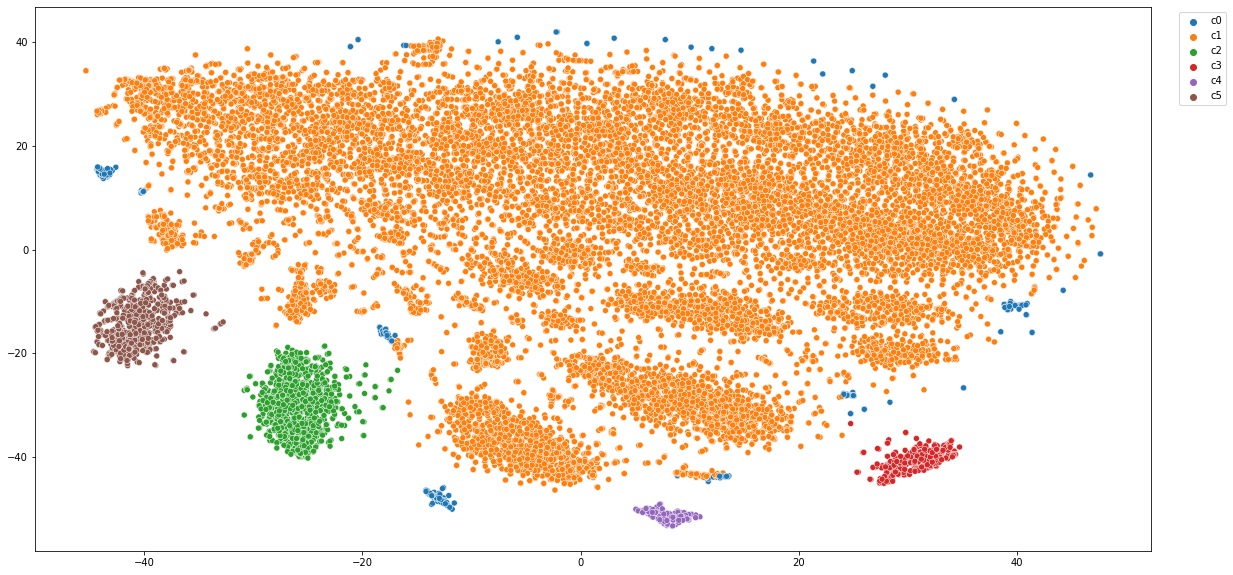

In [131]:
import seaborn as sns
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20, 10))
sns.scatterplot(x = transformed[:,0], y = transformed[:,1], hue=["c{}".format(x) for x in DBSCAN_labels])
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')

DBSCAN finding parameters with t-SNE

In [ ]:
#Def model:
model = TSNE(learning_rate = 100)

# Fitting model 
transformed = model.fit_transform(X)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster impor DBSCAN

fig = plt.figure(figsize=(20, 10))
fig.subplots_adjust(hspace=.5, wspace=.2)
i = 1
ran = np.arange(1.5, 2.5, 0.1)
for x in ran:
  eps = x
  db = DBSCAN(eps=eps, min_samples=20).fit(transformed)
  core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
  core_samples_mask[db.core_sample_indices_] = True
  labels = db.labels_
  print("eps:" + str(eps) + ", num_clusters:" + str(len(np.unique(labels))))
  ax = fig.add_subplot(2, 5, i)
  ax.text(1, 4, "eps = {}".format(round(eps, 1)), fontsize=25, ha="center")
  sns.scatterplot(x = transformed[:,0], y = transformed[:,1], hue=["cluster-{}".format(x) for x in labels], legend = False)
  i += 1

In [ ]:
#finding the optimal min_samples using visualization
fig = plt.figure(figsize=(20, 10))
fig.subplots_adjust(hspace=.5, wspace=.2)
i = 1
eps = 1.91
ran = np.arange(5,55,5)
for x in ran:
  min_s = x
  db = DBSCAN(eps=eps, min_samples=min_s).fit(transformed)
  core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
  core_samples_mask[db.core_sample_indices_] = True
  labels = db.labels_
  print("min_samples:" + str(min_s) + ", num_clusters:" + str(len(np.unique(labels))))
  ax = fig.add_subplot(2, 5, i)
  ax.text(1, 4, "m_s = {}".format(round(min_s, 1)), fontsize=25, ha="center")
  sns.scatterplot(x = transformed[:,0], y = transformed[:,1], hue=["cluster-{}".format(x) for x in labels], legend = False)
  i += 1

### Ok now run DBSCAN using the epsilon and min_samples we found

In [ ]:
from sklearn.cluster import DBSCAN
eps = knee.knee_y
DBSCAN_cluster = DBSCAN(eps=1.91, min_samples=25).fit(transformed)
#print(DBSCAN_cluster.labels_)

In [ ]:
num_outliers = np.sum(DBSCAN_cluster.labels_ == -1)
num_clusters = len(np.unique(DBSCAN_cluster.labels_)) - 1
percentage_outliers = num_outliers/len(DBSCAN_cluster.labels_) * 100
print("Num_outliers: " + str(num_outliers))
print("num clusters: " + str(num_clusters))
print("percentage of points that are outliers: " + str(percentage_outliers))

In [ ]:
DBSCAN_labels = DBSCAN_cluster.labels_
if (num_outliers > 0):
  #if there are outliers in the data, shift the data up to print the unlustered data, otherwise leave as is
  DBSCAN_labels = DBSCAN_labels + 1
labels_DBSCAN,connective_to_label_DBSCAN = view_labels(X, X_sentences, DBSCAN_labels, len(set(DBSCAN_labels)))

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20, 10))
sns.scatterplot(x = transformed[:,0], y = transformed[:,1], hue=["c{}".format(x) for x in labels])
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')

In [ ]:
label_DBSCAN